In [2]:
source('data/common.r')

# Rawmix

In [3]:
d <- data.rawmix(where="name like 'v0.28.1%' and nclients = 4 and duration = 30 and length = 4 and rate = 100 and timeout_scaling = 1000 and phase_limit = 100")

d$zipf <- num(d$alpha)

d.zipf <- subset(d, nkeys == 1000 & commute_ratio == 0.5)
  
d.zipf <- subset(d.zipf, select = c('name', 'nclients', 'nthreads', 'cc', 'phasing', 'cc_ph', 'rate',  'zipf', 'commute_ratio', 'timeout_scaling', 'throughput', 'op_timeouts', 'txn_failed'))

In [6]:
d.zipf.mean <- ddply(d.zipf, .(rate,nthreads,cc_ph,zipf,phasing,cc,timeout_scaling), summarize, throughput=mean(throughput), op_timeouts=mean(op_timeouts))

d.zipf.max <- ddply(d.zipf.mean, .(cc_ph,zipf,phasing,cc), summarize, throughput=max(throughput))

In [54]:
s.zipf <- subset(d.zipf.max, cc_ph %in% c(RW+PH, COMM+PH, COMB+PH, NOTXN))
s.zipf$throughput <- s.zipf$throughput / 1000

remap_cc_ph <- function(d) {
  m <- c()
  m[[RW+PH]] <- 'rw'
  m[[COMM+PH]] <- 'boosting'
  m[[COMB+PH]] <- 'boosting+combining'
  m[[NOTXN]]   <- 'non-transactional'
  revalue(d$cc_ph, m)
}

s.zipf$cc_ph <- remap_cc_ph(s.zipf)

r.zipf <- recast(s.zipf, zipf~cc_ph, mean, id.var = c('cc_ph', 'zipf', 'cc', 'phasing'))

write.csv(r.zipf, file = 'data/zipf_recast.csv')

write.table(r.zipf, file=stdout(), quote=FALSE, sep='\t', row.names = F)
r.zipf

zipf	non-transactional	boosting+combining	boosting	rw
0.2	19.0854831166846	12.056372730594	11.641839812794	10.840218520936
0.4	18.9037970313512	12.0476628599926	11.4427340945219	10.1835215235648
0.6	18.6377949113985	11.8454330460867	11.1535429861089	7.04877076509993
0.8	17.3783120610931	11.7650925170088	10.4049055783134	2.9136413003517
1	15.1201618074859	11.9616714766968	8.99619143160653	1.4781975507372
1.2	12.827573275743	12.4223362232747	7.75028331774701	0.959399659116793
1.4	10.9243697435805	12.4597098260294	6.54295687294332	0.753795498551801


,zipf,non-transactional,boosting+combining,boosting,rw
1,0.2,19.08548,12.05637,11.64184,10.84022
2,0.4,18.9038,12.04766,11.44273,10.18352
3,0.6,18.63779,11.84543,11.15354,7.048771
4,0.8,17.37831,11.76509,10.40491,2.913641
5,1,15.12016,11.96167,8.996191,1.478198
6,1.2,12.82757,12.42234,7.750283,0.9593997
7,1.4,10.92437,12.45971,6.542957,0.7537955


# Rubis

In [50]:
d <- data.rubis(where="duration = 60 and name like 'v0.29%' and nthreads <= 96 and total_time < 65")
d <- subset(d, select = c('name', 'nclients', 'nthreads', 'cc', 'rate', 'mix', 'alpha', 'lambda', 'nusers', 'ncategories', 'nregions', 'phasing', 'cc_ph', 'timeout_scaling', 'throughput', 'state', 'avg_latency_ms'))

d$x <- d$nthreads * num(d$nclients)

d <- subset(d, lambda == 20 & grepl('bid-heavy', mix) & nthreads != 80)

The following `from` values were not present in `x`: better#0, better#1
The following `from` values were not present in `x`: better#0, better#1
The following `from` values were not present in `x`: better#0#off#0, better#1#off#0, better#0#on#0, better#1#on#0


Warning message:
In number/sifactor[ix]: longer object length is not a multiple of shorter object length

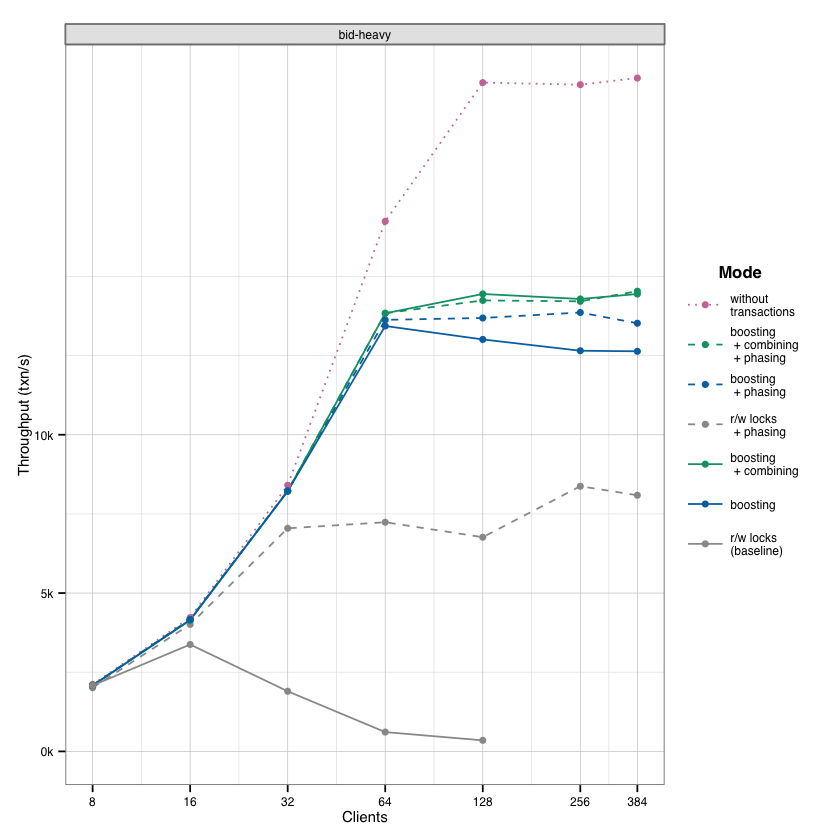

In [52]:
ggplot(subset(d), aes(
    x = x,
    y = throughput,
    group = cc_ph, fill = cc_ph, color = cc_ph, linetype = cc_ph
  ))+
  xlab('Clients')+ylab('Throughput (txn/s)')+
  stat_summary(geom='line', fun.y=mean)+
  stat_summary(geom='point', fun.y=mean, guide=F)+
  scale_x_continuous(trans=log2_trans(), breaks=c(8,16,32,64,128,256,384))+
  scale_y_continuous(breaks = c(0, 5000, 10000), labels = si.labels())+
  expand_limits(x=0, y=0)+
  facet_wrap(~mix, scales="free_x")+
  cc_ph_scales()+
  my_theme()

In [58]:
s <- subset(d, cc_ph %in% c(RW+PH, COMM+PH, COMB+PH, NOTXN), select = c('x', 'mix', 'cc_ph', 'throughput'))
s$throughput <- s$throughput / 1000
s$cc_ph <- remap_cc_ph(s)

In [62]:
r.rubis <- recast(s, x~cc_ph, mean, id.var = c('cc_ph', 'mix', 'x'))
write.table(r.rubis, file=stdout(), quote=FALSE, sep='\t', row.names = F)
r.rubis

x	non-transactional	boosting+combining	boosting	rw
8	2.11198441463441	2.08982276056612	2.08800849377686	2.00986475852449
16	4.22415718408607	4.17003571183191	4.16324039825758	4.01089405699308
32	8.40380886147721	8.2286858500093	8.22519370957714	7.04551441578738
64	16.7390901107918	13.8369690100772	13.6279123649027	7.23697363752685
128	21.1201004628883	14.2413686397923	13.6870549071041	6.76377533998373
256	21.0545821603992	14.2129193452241	13.8597164852615	8.37310383396087
384	21.2642741374336	14.533014705646	13.5209211022866	8.08967037809436


,x,non-transactional,boosting+combining,boosting,rw
1,8,2.111984,2.089823,2.088008,2.009865
2,16,4.224157,4.170036,4.16324,4.010894
3,32,8.403809,8.228686,8.225194,7.045514
4,64,16.73909,13.83697,13.62791,7.236974
5,128,21.1201,14.24137,13.68705,6.763775
6,256,21.05458,14.21292,13.85972,8.373104
7,384,21.26427,14.53301,13.52092,8.08967


# Retwis